## <center> Data engineer Home case


SUMMARY

Rosstat periodically provides different data about agriculture market.

The task is to automate the process of gathering and storing sample data (Harvested area) into database (using Python) and make some analytics based on downloaded data (using SQL)



TASKS:

1. Python
Write the python script (Jupyter Notebook preferable), that:

* Parses the data from https://www.fedstat.ru/indicator/31328


for every:
year [ 2016 – last available year], product [пшеница яровая, пшеница озимая, кукуруза на зерно], region	

In [74]:
import requests
from bs4 import BeautifulSoup

import os, os.path

import re

import pandas as pd
import datetime

import seaborn as sns

In [75]:
# Запрос к указанной странице и преобразование полученных данных к читабельному виду

url = 'https://www.fedstat.ru/indicator/31328'
response = requests.get(url)

display(response.status_code)

page = BeautifulSoup(response.text, 'html.parser')


200

Результат предыдущего запроса содержит информацию:

window['grid'] = new FGrid({
                        id: 31328,
                        block: $('#grid'),
                        debug: true,
                        title: '\u041F\u043E\u0441\u0435\u0432\u043D\u044B\u0435 \u043F\u043B\u043E\u0449\u0430\u0434\u0438 \u0441\u0435\u043B\u044C\u0441\u043A\u043E\u0445\u043E\u0437\u044F\u0439\u0441\u0442\u0432\u0435\u043D\u043D\u044B\u0445 \u043A\u0443\u043B\u044C\u0442\u0443\u0440',
                        unit: '\u0442\u044B\u0441\u044F\u0447\u0430 \u0433\u0435\u043A\u0442\u0430\u0440\u043E\u0432',
                        filters: {
                            0: {
                                title: '\u041F\u043E\u043A\u0430\u0437\u0430\u0442\u0435\u043B\u044C',
                                all: true,
                                values: {
                                    31328: {
                                        title: '\u041F\u043E\u0441\u0435\u0432\u043D\u044B\u0435 \u043F\u043B\u043E\u0449\u0430\u0434\u0438 \u0441\u0435\u043B\u044C\u0441\u043A\u043E\u0445\u043E\u0437\u044F\u0439\u0441\u0442\u0432\u0435\u043D\u043D\u044B\u0445 \u043A\u0443\u043B\u044C\u0442\u0443\u0440',
                                        order: 0,
                                        checked: true
                                    }
                                },
                                indicator: true
                            },
                            3: {
                                title: '\u0413\u043E\u0434',
                                all: false,
                                values: {
                                    1990: {
                                        title: '1990',
                                        order: 0,
                                        checked: false
...

Из этого можно извлечь коды полей, с которыми в дальнейшем предстоит работать, чтобы извлечь конкетные цифры. Для этого пришлось сопоставить структуру New FGrid с информацией на сайте.

Периоды: поле имеет код 3, значениями являются годы, нас интересуют 2016-2021

Единица измерения: код 0, значение 31328 - тысяча гектаров (совпадает с кодом индикатора)

Хозяйства: код поля 58423, нас интересует значение "все", его код 1750642

Сельхоз культуры: поле 58745, значения 1752006 - кукуруза на зерно, 1752003 - пшеница озимая и 1752009 - пшеница яровая

Регионы: поле 57831. Нас интересуют все значения, кроме итоговых полей

 ( например Российская Федерация или Южный Федеральный округ). 

In [76]:
# Использовала чужое решение, чтобы понять, какой структуры должен быть запрос, и к какой странице обращаться
# для получения данных
# https://github.com/infoculture/hubofdata/blob/master/scripts/catalogs/fedstatru/emiss_extract.py

url_data = 'https://fedstat.ru/indicator/data.do' # страница, содержащая данные

# Сложно сходу предложить менее громоздкое решение. Альтернативный вариант - задать списки значений полей
# например region_list = [1688580, 1688581, ...] для регионов, и затем формировать список со структурой запроса в цикле
# Если мы будем часто обращаться к данным ЕМИСС, думаю будет иметь смысл оформить такие списки, и возможно вынести их в отдельный модуль 

dp = [#('lineObjectIds', '0'), # необходимые поля и значения
 ('lineObjectIds', '57831'), #строки: регионы, годы, сельхоз культуры
 ('lineObjectIds', '3'),
 ('lineObjectIds', '58745'),
 ('columnObjectIds', '58423'), #столбец: виды хозяйств
 ('selectedFilterIds', '0_31328'), # единицы измерения
 ('selectedFilterIds', '3_31328'),
 ('selectedFilterIds', '3_2016'), # периоды
 ('selectedFilterIds', '3_2017'),
 ('selectedFilterIds', '3_2018'),
 ('selectedFilterIds', '3_2019'),
 ('selectedFilterIds', '3_2020'),
 ('selectedFilterIds', '3_2021'),
 ('selectedFilterIds', '58423_1750642'), # виды хозяйств
 ('selectedFilterIds', '57831_1750643'), # регионы
 ('selectedFilterIds', '57831_1688489'),
 ('selectedFilterIds', '57831_1688490'),
 ('selectedFilterIds', '57831_1688491'),
 ('selectedFilterIds', '57831_1688492'),
 ('selectedFilterIds', '57831_1688493'),
 ('selectedFilterIds', '57831_1688494'),
 ('selectedFilterIds', '57831_1688495'),
 ('selectedFilterIds', '57831_1688496'),
 ('selectedFilterIds', '57831_1688497'),
 ('selectedFilterIds', '57831_1688498'),
 ('selectedFilterIds', '57831_1688499'),
 ('selectedFilterIds', '57831_1688500'),
 ('selectedFilterIds', '57831_1688501'),
 ('selectedFilterIds', '57831_1688502'),
 ('selectedFilterIds', '57831_1688503'),
 ('selectedFilterIds', '57831_1688504'),
 ('selectedFilterIds', '57831_1688505'),
 ('selectedFilterIds', '57831_1688506'),
 ('selectedFilterIds', '57831_1688508'),
 ('selectedFilterIds', '57831_1688509'),
 ('selectedFilterIds', '57831_1688510'),
 ('selectedFilterIds', '57831_1688513'),
 ('selectedFilterIds', '57831_1688514'),
 ('selectedFilterIds', '57831_1688515'),
 ('selectedFilterIds', '57831_1688516'),
 ('selectedFilterIds', '57831_1688517'),
 ('selectedFilterIds', '57831_1688518'),
 ('selectedFilterIds', '57831_1688519'),
 ('selectedFilterIds', '57831_1688522'),
 ('selectedFilterIds', '57831_1688523'),
 ('selectedFilterIds', '57831_1692938'),
 ('selectedFilterIds', '57831_1688524'),
 ('selectedFilterIds', '57831_1688525'),
 ('selectedFilterIds', '57831_1688526'),
 ('selectedFilterIds', '57831_1688527'),
 ('selectedFilterIds', '57831_1695534'),
 ('selectedFilterIds', '57831_1688529'),
 ('selectedFilterIds', '57831_1688530'),
 ('selectedFilterIds', '57831_1688531'),
 ('selectedFilterIds', '57831_1688532'),
 ('selectedFilterIds', '57831_1688533'),
 ('selectedFilterIds', '57831_1688534'),
 ('selectedFilterIds', '57831_1688535'),
 ('selectedFilterIds', '57831_1688537'),
 ('selectedFilterIds', '57831_1688538'),
 ('selectedFilterIds', '57831_1688539'),
 ('selectedFilterIds', '57831_1688540'),
 ('selectedFilterIds', '57831_1688541'),
 ('selectedFilterIds', '57831_1688542'),
 ('selectedFilterIds', '57831_1688543'),
 ('selectedFilterIds', '57831_1688545'),
 ('selectedFilterIds', '57831_1688546'),
 ('selectedFilterIds', '57831_1688547'),
 ('selectedFilterIds', '57831_1688548'),
 ('selectedFilterIds', '57831_1688549'),
 ('selectedFilterIds', '57831_1688550'),
 ('selectedFilterIds', '57831_1688551'),
 ('selectedFilterIds', '57831_1688553'),
 ('selectedFilterIds', '57831_1688554'),
 ('selectedFilterIds', '57831_1688555'),
 ('selectedFilterIds', '57831_1688559'),
 ('selectedFilterIds', '57831_1688561'),
 ('selectedFilterIds', '57831_1688563'),
 ('selectedFilterIds', '57831_1688564'),
 ('selectedFilterIds', '57831_1688565'),
 ('selectedFilterIds', '57831_1688568'),
 ('selectedFilterIds', '57831_1688569'),
 ('selectedFilterIds', '57831_1688570'),
 ('selectedFilterIds', '57831_1688571'),
 ('selectedFilterIds', '57831_1688572'),
 ('selectedFilterIds', '57831_1688573'),
 ('selectedFilterIds', '57831_1688574'),
 ('selectedFilterIds', '57831_1688575'),
 ('selectedFilterIds', '57831_1688576'),
 ('selectedFilterIds', '57831_1688562'),
 ('selectedFilterIds', '57831_1688566'),
 ('selectedFilterIds', '57831_1688567'),
 ('selectedFilterIds', '57831_1688578'),
 ('selectedFilterIds', '57831_1688579'),
 ('selectedFilterIds', '57831_1688580'),
 ('selectedFilterIds', '57831_1688581'),
 ('selectedFilterIds', '57831_1688582'),
 ('selectedFilterIds', '57831_1688583'),
 ('selectedFilterIds', '57831_1688584'),
 ('selectedFilterIds', '57831_1688585'),
 ('selectedFilterIds', '57831_1688586'),
 ('selectedFilterIds', '57831_1688587'),
 ('selectedFilterIds', '30611_1698485'),
 ('selectedFilterIds', '30611_950283'),
 ('selectedFilterIds', '33560_950283'),
 ('selectedFilterIds', '33560_1558883'),
 ('selectedFilterIds', '33560_1558883'),
 ('selectedFilterIds', '58745_1752006'), # сельхоз культуры
 ('selectedFilterIds', '58745_1752023'),
 ('selectedFilterIds', '58745_1752009'),
 ('id', '31328')] # показатель

params = (('format', 'excel'),)


resp = requests.post(url_data, params=params, data=dp)


In [77]:
# Сохранение данных в Excel

f = open('data_31328_new.xlsx', 'wb')
f.write(resp.content)
f.close()

In [78]:
# Преобразование Excel файла

data = pd.read_excel('data_31328_new.xlsx', header=2, sheet_name='Данные')

data['region_name'] = data['Unnamed: 0']
data['begin_date'] = data['Unnamed: 1'].apply(lambda x: datetime.date(x, 1, 1))
data['end_date'] = data['Unnamed: 1'].apply(lambda x: datetime.date(x, 12, 31))
#data['begin_date'] = pd.to_datetime(data['begin_date'])
#data['end_date'] = pd.to_datetime(data['end_date'])
data['product_type'] = data['Unnamed: 2']
data['volume'] = data['Хозяйства всех категорий']

data = data.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Хозяйства всех категорий'], axis = 1)

data.info()
data.head(10)

# Запишем данные в финальный файл
data.to_excel('data_31328_final.xlsx', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region_name   1166 non-null   object 
 1   begin_date    1166 non-null   object 
 2   end_date      1166 non-null   object 
 3   product_type  1166 non-null   object 
 4   volume        1166 non-null   float64
dtypes: float64(1), object(4)
memory usage: 45.7+ KB


* Inserts these data into database table (Postgres preferable) with the structure:

region_name, begin_date, end_date, product_type, volume

In [79]:
# Здесь будет блок кода по переносу данных из Excel в базу Postgres

Provide some primary data analysis

In [82]:
data = pd.read_excel('data_31328_final.xlsx')

# Уникальные значения каждого поля
data.nunique()


region_name       76
begin_date         6
end_date           6
product_type       3
volume          1003
dtype: int64

Все значения представляют собой категории, что понятно из условия задачи. Посмотрим подробнее на поле volume

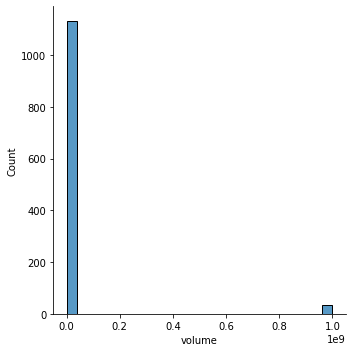

In [85]:
# Распределение значений поля volume 
sns.displot(data=data, x='volume', bins=25)


In [87]:
# На графике видны выбросы, посмотрим на них подробнее. Возможно это ошибки в данных ЕМИСС
data[data['volume']>0.2e+9]

,region_name,begin_date,end_date,product_type,volume
113,Костромская область,2021-01-01,2021-12-31,Пшеница озимая,999999999.0
249,Тверская область,2019-01-01,2019-12-31,Кукуруза на зерно,999999999.0
287,Ярославская область,2021-01-01,2021-12-31,Пшеница яровая,999999999.0
294,Город Москва столица Российской Федера...,2018-01-01,2018-12-31,Пшеница озимая,999999999.0
295,Город Москва столица Российской Федера...,2018-01-01,2018-12-31,Пшеница яровая,999999999.0
296,Город Москва столица Российской Федера...,2019-01-01,2019-12-31,Пшеница озимая,999999999.0
297,Город Москва столица Российской Федера...,2020-01-01,2020-12-31,Пшеница озимая,999999999.0
298,Город Москва столица Российской Федера...,2020-01-01,2020-12-31,Пшеница яровая,999999999.0
299,Город Москва столица Российской Федера...,2021-01-01,2021-12-31,Пшеница озимая,999999999.0
300,Город Москва столица Российской Федера...,2021-01-01,2021-12-31,Пшеница яровая,999999999.0
